# Custom VQA Ingredient with LLaVA

<span style="color: red;">NOTE: This notebook is using an old version of blendsql. The same ideas apply, but syntax might differ in the latest version. Reach out in [our Discord](https://discord.gg/vCv7ak3WrU), or email me at parkervg5@gmail.com if you want help!</span>

Below, we use BlendSQL on a multi-table database containing data from https://en.wikipedia.org/wiki/Fountains_in_Portland,_Oregon.

- `w`: Structured data
- `documents`: Unstructured article content
- `images`: Images stored as bytes from the article

We demonstrate how BlendSQL can be used to call a tiny VQA (visual question-answering) model (https://huggingface.co/bczhou/tiny-llava-v1-hf) and do reasoning over various forms of data.

This is a simple example of the approach taken in [EHRXQA: A Multi-Modal Question Answering Dataset for Electronic Health Records with Chest X-ray Images](https://arxiv.org/pdf/2310.18652.pdf)

In [1]:
from typing import List
from blendsql import blend
from blendsql.models import TransformersLLM, ModelObj
from blendsql.ingredients import MapIngredient, IngredientException
from blendsql.utils import fetch_from_hub
from blendsql.db import SQLite

In [2]:
db = SQLite(fetch_from_hub("Fountains_in_Portland,_Oregon_0.db"))

In [3]:
db.execute_to_df("SELECT * FROM w;")

,index,title,designer ( s ),year
0,0,animals in pools,georgia gerber,1986
1,1,the car wash ( officially untitled ),"carter , hull , nishita , mcculley and baxter",1977
2,2,the dreamer,manuel izquierdo,1979
3,3,elk,roland hinton perry,1900
4,4,holladay park fountain,tim clemen ( murase associates ),2000
5,5,keller fountain,angela danadjieba ( lawrence halprin associates ),1971
6,6,kelly fountain,lee kelly,1977
7,7,lovejoy fountain,lawrence halprin associates,1968
8,8,mccoy fountain,murase associates,2000
9,9,pioneer courthouse square waterfall fountain,will martin,1983


In [29]:
try:
    from PIL import Image
except:
    print("Installing pillow...")
    !pip install pillow
    from PIL import Image
# Create our custom ingredient as a child of `MapIngredient`
from io import BytesIO
from transformers import pipeline

class VQAModel(TransformersLLM):
    
    def _load_model(self) -> ModelObj:
        return pipeline("image-to-text", model=self.model_name_or_path)

    def predict(self, question: str, img_bytes: List[bytes]) -> str:
        prompt = f"USER: <image>\n{question}"
        model_output = self.model_obj(
            images=[
                Image.open(BytesIO(value)) for value in img_bytes
            ],
            prompt=prompt,
            generate_kwargs={"max_new_tokens": 200}
        )
        return [output[0]["generated_text"].lstrip(prompt).strip() for output in model_output]

class VQA(MapIngredient):
    def run(self, model: VQAModel, question: str, values: List[bytes], **kwargs):
        """Given a list of byte arrays, calls a tiny Llava model
        to answer a given question.
        """
        if not all(isinstance(value, bytes) for value in values):
            raise IngredientException(f"All values must be 'byte' type for LlavaVQA!")
        model_output = model.predict(question=question, img_bytes=values)
        return model_output

In [30]:
# Initialize our VQA model
model = VQAModel(model_name_or_path="bczhou/tiny-llava-v1-hf")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Simple Image Description

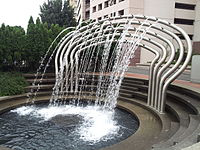

In [31]:
b = db.execute_to_list("SELECT img_bytes FROM images WHERE title = 'the car wash ( officially untitled )'")[0]
Image.open(BytesIO(b))

In [ ]:
smoothie = blend(
    query="""
    SELECT {{VQA('What is in this image?', 'images::img_bytes')}}
        FROM images WHERE title = 'the car wash ( officially untitled )'
    """,
    db=db,
    ingredients={VQA},
    default_model=model
)

In [33]:
smoothie.df.values[0][0]

'A large, curved, waterfall-like fountain is located in a park. The fountain is surrounded by a concrete walkway, and it is surrounded by trees.'

## Multi-hop, Multi-modal Reasoning

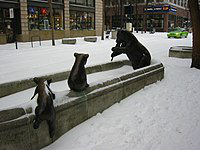

In [20]:
b = db.execute_query("SELECT img_bytes FROM images WHERE title = 'animals in pools'").values[0][0]
Image.open(BytesIO(b))

In [22]:
# How many animals are in the fountain designed by Georgia Gerber?
smoothie = blend(
    query="""
    SELECT w.title, w."designer ( s )", {{VQA('How many animals are in this fountain?', 'images::img_bytes')}}
        FROM images JOIN w ON w.title = images.title
        WHERE "designer ( s )" = 'georgia gerber'
    """,
    db=db,
    ingredients={VQA},
    default_model=model
)

In [23]:
smoothie.df

,title,designer ( s ),How many animals are in this fountain?
0,animals in pools,georgia gerber,There are three animals in the fountain.
